In [1]:
import numpy as np
import scipy as sci
import eddington
import os
import pickle
from matplotlib import pyplot as plt
import matplotlib as mpl
from bisect import bisect
plt.rcParams['figure.figsize'] = [20,10]
plt.rcParams.update({'font.size': 18, 'font.weight':'bold'})
plt.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
brn = r'Measurements/Brine/' # Path to pickles directory

with open(brn+'EnergyChannel.pickle', "rb") as f:
    engCali = pickle.load(f)
    
with open(brn+'Efficiency.pickle', "rb") as f:
    reLin = pickle.load(f)

In [2]:
@eddington.fitting_function(
    n=3,
    syntax="a[0]**2 * (1+np.cos(x-a[1])**2)/2 *\
            1/(1+a[2]*(1-np.cos(x-a[1])))**2 *\
            (1+a[2]**2*(1-np.cos(x-a[1]))**2)/\
            ((1+np.cos(x-a[1])**2)*(1+a[2]*(1-np.cos(x-a[1]))))")
def NishinaCrossSection(a,x):
    return  a[0]**2 * (1+np.cos(x-a[1])**2)/2 *\
            1/(1+np.abs(a[2])*(1-np.cos(x-a[1])))**2 *\
            ( 1 + a[2]**2*(1-np.cos(x-a[1]))**2/\
            ((1+np.cos(x-a[1])**2)*(1+np.abs(a[2])*(1-np.cos(x-a[1])))) )

@eddington.fitting_function(
    n=2,
    syntax="a[0]**2 * (1+np.cos(x-a[1])**2)/2")
def ThomsonCrossSection(a,x):
    return a[0]**2 * (1+np.cos(x-a[1])**2)/2

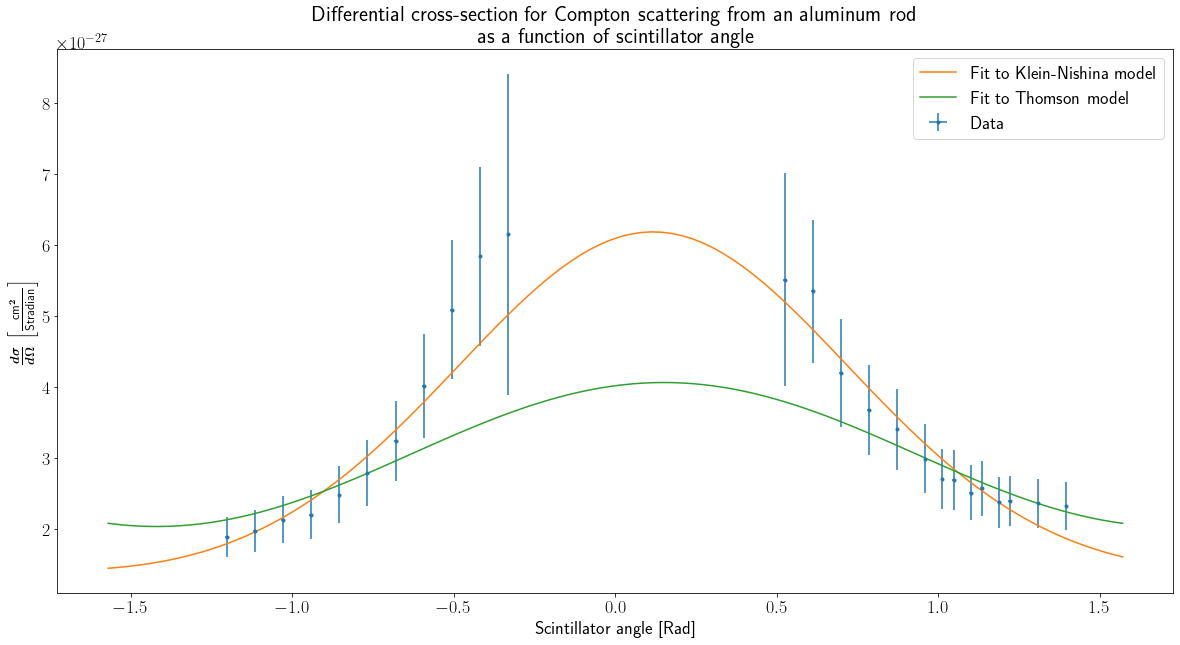

In [3]:
with open(brn+'SciMu.pickle', 'rb') as f:
    mu2 = pickle.load(f)
    
with open(brn+'AlRodMu.pickle', 'rb') as f:
    mu1 = pickle.load(f)

mu1[2] = mu1[2]*np.pi/180
mu1[3] = mu1[3]*np.pi/180
mu2[2] = mu2[2]*np.pi/180
mu2[3] = mu2[3]*np.pi/180

r0 = 2.82*10**(-13) # cm
sDet = np.pi*(7.62/2)**2 # cm^2
RAl = 15 #cm
Rsal = 81 #cm
AeffAl = 1.2*7 # cm^2
AeffSci = 32*70/100 #cm^2
l = [np.pi*1.2/2, np.pi*32/10]
ne = [2.710/26.982 * 13 * 6.02214076*10**(23), 3.39*10**22]
NiN = [85.1/100*3.7*10**9*2**(-(2022-1981)/30.07)*mu1[6]*AeffAl/(4*np.pi*Rsal**2), 
       85.1/100*3.7*10**9*2**(-(2022-1981)/30.07)*mu2[6]*AeffSci/(4*np.pi*Rsal**2)] 
Nsc = [mu1[4]/eddington.linear(reLin.a, eddington.linear(engCali.a,mu1[0])),
       mu2[4]/eddington.linear(reLin.a, eddington.linear(engCali.a,mu2[0]))]

dNsc = [Nsc[0]*np.sqrt((mu1[5]/mu1[4])**2+\
        (reLin.aerr[0]**2+reLin.aerr[1]**2*eddington.linear(engCali.a,mu1[0])**2)*(Nsc[0]/mu1[4])**2),
        Nsc[1]*np.sqrt((mu2[5]/mu2[4])**2+\
        (reLin.aerr[0]**2+reLin.aerr[1]**2*eddington.linear(engCali.a,mu2[0])**2)*(Nsc[1]/mu2[4])**2)]

dOmega = 2*1/(np.sqrt(12)*RAl)
dNiN = [0.02*NiN[0], 0.02*NiN[1]] # DI_gamma/I_gamma = DNiN/NiN

dsdO=[Nsc[0]*(RAl**2/sDet)/(NiN[0]*ne[0]*l[0]),
      Nsc[1]*(RAl**2/sDet)/(NiN[1]*ne[1]*l[1])]
DdsdO = [dsdO[0]*np.sqrt((dNsc[0]/Nsc[0])**2+(dOmega)**2+(dNiN[0]/NiN[0])**2), 
         dsdO[1]*np.sqrt((dNsc[1]/Nsc[1])**2+(dOmega)**2+(dNiN[1]/NiN[1])**2)]

# DdsdO = [dsdO[0]*np.sqrt((dOmega)**2+(dNiN[0]/NiN[0])**2), 
#          dsdO[1]*np.sqrt((dOmega)**2+(dNiN[1]/NiN[1])**2)]

alData = eddington.FittingData(dict(x=mu1[2], dx=mu1[3],y=dsdO[0], dy=DdsdO[0]))
sciData = eddington.FittingData(dict(x=mu2[2], dx=mu2[3],y=dsdO[1], dy=DdsdO[1]))

alRe = eddington.fit(alData, NishinaCrossSection, a0=[r0/np.sqrt(10), 6*np.pi/180, 661/511])
sciRe = eddington.fit(sciData, NishinaCrossSection, a0=[r0/np.sqrt(10), 6*np.pi/180, 661/511])

alThomRe = eddington.fit(alData, ThomsonCrossSection, a0=[r0/np.sqrt(5), 6*np.pi/180])
sciThomRe = eddington.fit(sciData, ThomsonCrossSection, a0=[r0/np.sqrt(5), 6*np.pi/180])

alRe.save_txt('Fits/NishinaAl.txt')
sciRe.save_txt('Fits/NishinaSci.txt')
alThomRe.save_txt('Fits/ThomsonAl.txt')
sciThomRe.save_txt('Fits/ThomsonSci.txt')

scale = 10
smtX = np.linspace(-np.pi/2,np.pi/2, num=100)
plt.errorbar(x=alData.x,y=alData.y, xerr=alData.xerr, yerr=alData.yerr, fmt='.', label='Data')
plt.plot(smtX, NishinaCrossSection(alRe.a,smtX), label='Fit to Klein-Nishina model')
plt.plot(smtX, ThomsonCrossSection(alThomRe.a,smtX), label='Fit to Thomson model')
# plt.plot(smtX, 1/scale * ThomsonCrossSection([r0, 6*np.pi/180],smtX), label = f'Theoretical Thomson model \nrescaled by a factor of {scale}')
# plt.plot(smtX, 1/scale * NishinaCrossSection([r0, 6*np.pi/180, 661/511],smtX), label = f'Theoretical Nishina model \nrescaled by a factor of {scale}')
plt.legend()
plt.xlabel('Scintillator angle [Rad]')
plt.ylabel(r'$\boldsymbol{\frac{d\sigma}{d\Omega}}$ $\left[ \boldsymbol{\frac{\text{cm}^2}{\text{Stradian}}}\right]$')
plt.title(r'Differential cross-section for Compton scattering from an aluminum rod'+'\nas a function of scintillator angle')
plt.savefig('Fits/NishinaAl.png')
plt.savefig('Fits/NishinaAl.pdf')
plt.show()

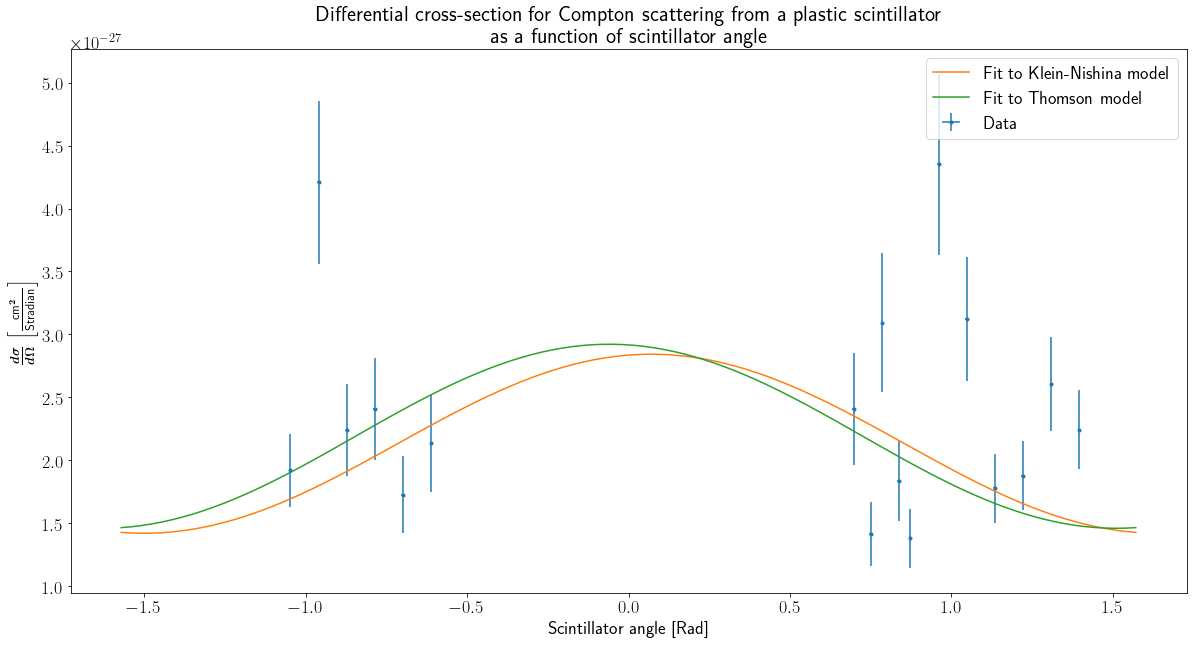

In [4]:
sciRe = eddington.fit(sciData, NishinaCrossSection, a0=[r0/np.sqrt(20), 0.1, 0.5])
sciThomRe = eddington.fit(sciData, ThomsonCrossSection, a0=[r0/np.sqrt(20), 0.1])
plt.errorbar(x=sciData.x,y=sciData.y, xerr=sciData.xerr, yerr=sciData.yerr, fmt='.', label='Data')
plt.plot(smtX, NishinaCrossSection(sciRe.a,smtX), label='Fit to Klein-Nishina model') # rewrite Nishina to have the zero angle set
plt.plot(smtX, ThomsonCrossSection(sciThomRe.a,smtX), label='Fit to Thomson model')
plt.legend()
plt.xlabel('Scintillator angle [Rad]')
plt.ylabel(r'$\boldsymbol{\frac{d\sigma}{d\Omega}}$ $\left[ \boldsymbol{\frac{\text{cm}^2}{\text{Stradian}}}\right]$')
plt.title(r'Differential cross-section for Compton scattering from a plastic scintillator'+'\nas a function of scintillator angle')
plt.savefig('Fits/NishinaSci.png')
plt.savefig('Fits/NishinaSci.pdf')
plt.show()

sciRe.save_txt('Fits/NishinaSci.txt')
sciThomRe.save_txt('Fits/ThomsonSci.txt')

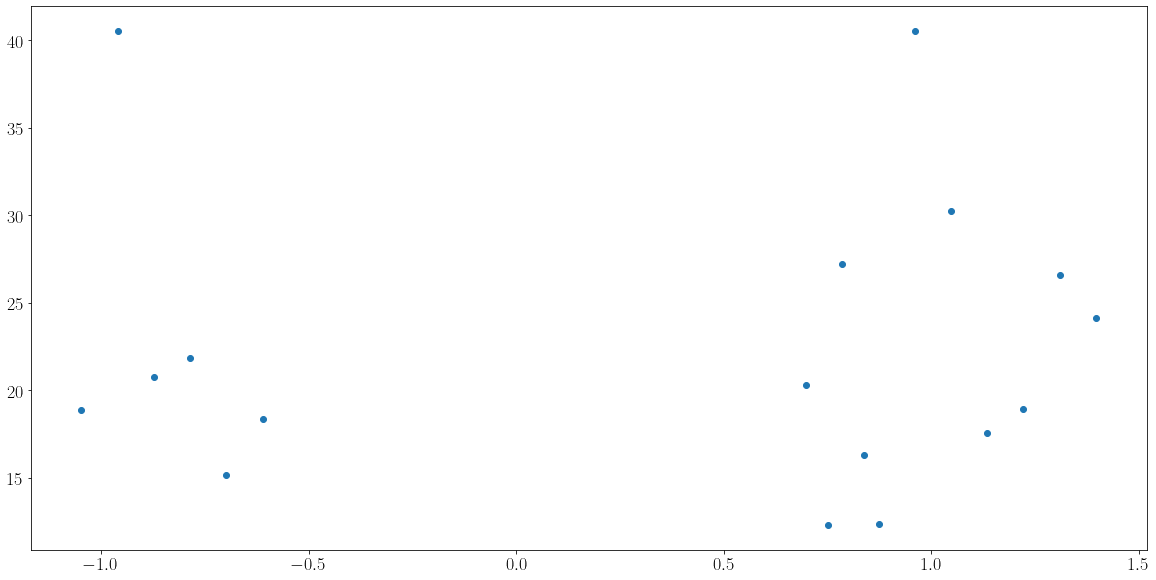

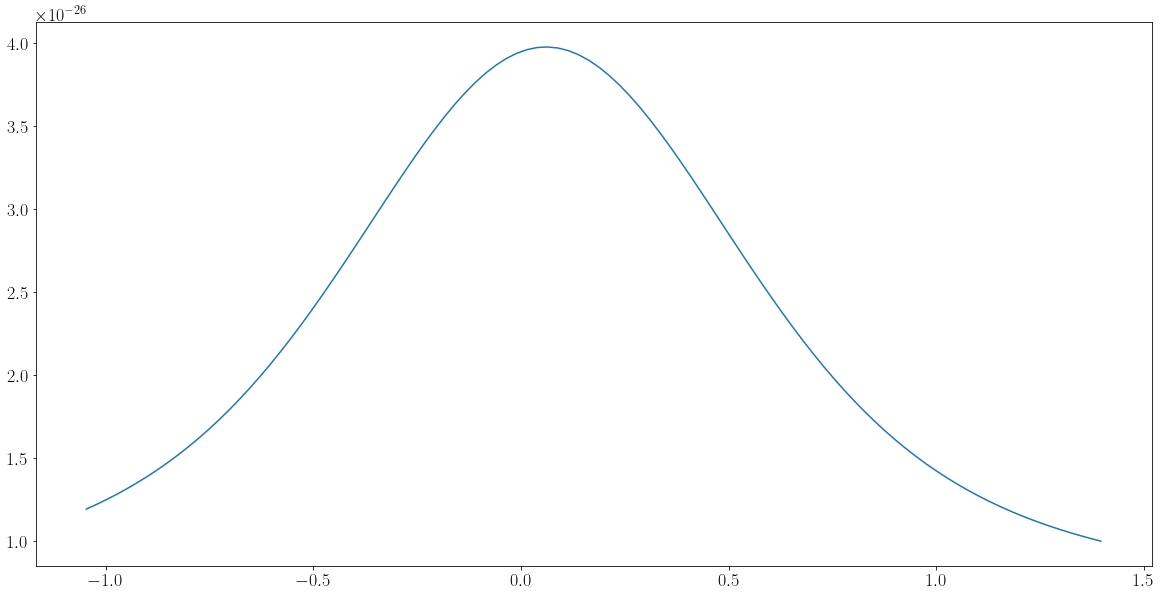

In [32]:
NiN = 85.1/100*3.7*10**9*2**(-41/30.07)*mu2[6]*AeffSci/(4*np.pi*Rsal**2)
Nsc= mu2[4]/eddington.linear(reLin.a, eddington.linear(engCali.a,mu2[0]))
x = np.linspace(min(mu2[2])*np.pi/180, max(mu2[2])*np.pi/180, num=100)
dsdO = Nsc*(RAl**2/sDet)/(NiN*ne[1]*l[1])

plt.scatter(mu2[2]*np.pi/180, mu2[4]/mu2[6])
# plt.scatter(mu2[2]*np.pi/180, mu2[4]/10**6)
plt.show()
plt.plot(x, NishinaCrossSection([r0, 3.45*np.pi/180, 661/511],x))
plt.show()